In [ ]:
#Si mettono a confronto 2 modelli di probabilità di default di clientela retail: un modello classico (regressione logistica) ed un modello RNN

#Il modello stima la probabilità di default dei clienti detentori di mutui ipotecari usando come variabile di ingresso il saldo del conto corrente. La tecnica classica prevede un modello semplice che elebora l'ultimo saldo del conto corrente, senza considerare lo storico (che le banche hanno comunque a disposizione). Lo scopo del progetto è valutare i progressi che si possono ottenere considerando non solo l'ultima foto del conto, ma anche la sua evoluzione negli ultimi 18 mesi, dando in pasto la serie storica dei 18 mesi ad un modello RNN (recurrent neural network)

#la base dati comprende circa un milione di clienti su 4 file. 1) File con indicatore di default a 12 mesi dalla rilevazione (variabile dipendente). 2) File dei saldi (una riga per ogni cliente, con gli ultimi 18 saldi mensili). 3) File dei movimenti avere (una riga per ogni cliente, con gli ultimi 18 importi di movimento mensile). 4) File degli importi accordati (una riga per ogni cliente, con gli ultimi 18 importi di fido accordato). Il 70% della base dati è usata in stima, il 30% in validazione

#Lo scopo del progetto è valutare la differente accuratezza dei modelli (metrica tensorflow AUC), ma soprattutto il differente impatto in termini di capitale regolamentare richiesto a copertura del rischio (metrica user defined RWA)

#Liberare capitale significa: 1) poter dedicare il capitale liberato ad altri impieghi 2) Maggiore redditività. Anticipando i risultati finali:
#Il modello RNN stima con più accuratezza (AUC 0.78 contro AUC 0.74), ed il capitale regolamentare assorbito dal set di validazione scende del 5%

#A titolo di esempio: il capitale assorbito dal gruppo Intesa a copertura del rischio mutui si aggira attorno a 10^9 euro, il cui 5% = 5*10^7 (50 milioni di risparmio)


In [ ]:
import tensorflow as tf
import csv
import numpy as np

nmesi=18
#funzione che carica un file csv con 18 importi mensili per riga, dal più vecchio al più recente
def loadcsv(filename):
  importi_clienti=[]
  with open(filename) as csvfile:
    reader = csv.reader(csvfile, delimiter=';')
    next(reader)
    for row in reader:
      importi_cliente_sing=[]
      for i in range(nmesi):
        #l'importo viene mappato su una scala discreta logaritma
        importo=float(row[i].replace(',','.'))
        importo_abs=np.abs(float(importo))
        importo_sign=np.sign(float(importo))
        if (importo_abs < 100):
          importo_dec=importo_sign
        else:           
          importo_log=int(np.log10(importo_abs))-1
          importo_dec=(importo_log*2 + (1 if importo_abs / np.power(10,importo_log) > 5.0 else 0))*importo_sign
        importi_cliente_sing.append(int(importo_dec))
      importi_clienti.append(np.array(importi_cliente_sing))
  importi_clienti = np.array(importi_clienti)
  min_importo_dec=importi_clienti.min()
  max_importo_dec=importi_clienti.max()
  #si rimappano i saldi su un intervallo positivo
  importi_clienti=importi_clienti-min_importo_dec
  #si tiene traccia della lunghezza del dizionario degli importi decodificati
  input_dim=max_importo_dec-min_importo_dec+1
  content_dic={"importi_clienti":importi_clienti,"input_dim":input_dim}
  return content_dic

#carica il file degli indicatori di default a 12 mesi
def loadcsv_y(filename):
  ind_def=[]
  with open(filename) as csvfile:
    reader = csv.reader(csvfile, delimiter=';')
    next(reader)
    for row in reader:
      ind_def.append(int(row[0]))
  ind_def = np.array(ind_def)
  return ind_def

#carica il file con i 18 saldi
csvcontent_saldi=loadcsv('./drive/MyDrive/temp/cc saldi.csv')
#carica il file con i 18 importi cumulati delle movimentazioni  
csvcontent_mov_av=loadcsv('./drive/MyDrive/temp/cc mov av.csv')  
#carica il file con i 18 importi dei fidi
csvcontent_acc=loadcsv('./drive/MyDrive/temp/cc acc.csv')  
#carica gli indicatori di solvibilità
ind_def=loadcsv_y('./drive/MyDrive/temp/ind def.csv')
#caricati in totale 943072 clienti
print (tf.shape(csvcontent_saldi["importi_clienti"]))
print (tf.shape(csvcontent_mov_av["importi_clienti"]))
print (tf.shape(csvcontent_acc["importi_clienti"]))
print (tf.shape(ind_def))

tf.Tensor([943072     18], shape=(2,), dtype=int32)
tf.Tensor([943072     18], shape=(2,), dtype=int32)
tf.Tensor([943072     18], shape=(2,), dtype=int32)
tf.Tensor([943072], shape=(1,), dtype=int32)


In [ ]:
#metrica user defined che esegue il calcolo del capitale regolamentare richiesto a copertura del rischio stimato di probabilità di default
import tensorflow_probability as tfp

dist=tfp.distributions.Normal(0,1)

def compute_rwa(x):
  #calcolo capitale secondo formula regolamentare
  return dist.cdf(dist.quantile(x)/tf.math.sqrt (0.85)+tf.math.sqrt (0.15/0.85)*dist.quantile(0.999))

class RWA(tf.keras.metrics.Metric):
  def __init__(self, name='RWA', **kwargs):
    super(RWA, self).__init__(name=name, **kwargs)
    self.rwa = self.add_weight(name='tp', initializer='zeros')


  def update_state(self, y_true, y_pred, sample_weight=None):
    values=tf.map_fn(compute_rwa, y_pred)
    self.rwa.assign_add(tf.reduce_sum(values))

  def result(self):
    return self.rwa

stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)

In [ ]:
#approccio classico: si stimano 3 regressioni logistiche rispetto ai valori dell'ultimo mese di saldo,movimentazioni e accordato. Si esegue poi un'integrazione dei 3 modelli con un'ulteriore logistica

#regressione logistica rispetto al saldo ultimo mese
ml=tf.keras.models.Sequential([
  tf.keras.layers.CategoryEncoding(num_tokens=csvcontent_saldi["input_dim"],output_mode="multi_hot")
  ,tf.keras.layers.Dense(1)
])
ml.compile(optimizer="adam",loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))#,metrics=[tf.keras.metrics.AUC()])
ml.fit(x=csvcontent_saldi["importi_clienti"][:,-1],y=ind_def
       ,validation_split=0.3,epochs=1000,batch_size=1024,callbacks=[stop_callback],shuffle=True,verbose=0)
ml.trainable=False

#regressione logistica rispetto alla movimentazione dell'ultimo mese
ml_av=tf.keras.models.Sequential([
  tf.keras.layers.CategoryEncoding(num_tokens=csvcontent_mov_av["input_dim"],output_mode="multi_hot")
  ,tf.keras.layers.Dense(1)
])
ml_av.compile(optimizer="adam",loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))#,metrics=[tf.keras.metrics.AUC()])
ml_av.fit(x=csvcontent_mov_av["importi_clienti"][:,-1],y=ind_def
          ,validation_split=0.3,epochs=1000,batch_size=1024,callbacks=[stop_callback],shuffle=True,verbose=0)
ml_av.trainable=False

#regressione logistica rispetto all'accordato dell'ultimo mese
ml_acc=tf.keras.models.Sequential([
  tf.keras.layers.CategoryEncoding(num_tokens=csvcontent_acc["input_dim"],output_mode="multi_hot")
  ,tf.keras.layers.Dense(1)
])
ml_acc.compile(optimizer="adam",loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))#,metrics=[tf.keras.metrics.AUC()])
ml_acc.fit(x=csvcontent_acc["importi_clienti"][:,-1],y=ind_def
           ,validation_split=0.3,epochs=1000,batch_size=1024,callbacks=[stop_callback],shuffle=True,verbose=0)
ml_acc.trainable=False

#integrazione dei 3 moduli con un'ulteriore logistica
conc_l=tf.keras.layers.Concatenate()([ml.output,ml_av.output,ml_acc.output])
dns_fin=tf.keras.layers.Dense(1,activation="sigmoid")(conc_l)
ml_fin=tf.keras.Model(inputs=[ml.input,ml_av.input,ml_acc.input],outputs=[dns_fin])
ml_fin.compile(optimizer="adam",loss=tf.keras.losses.binary_crossentropy,metrics=[tf.keras.metrics.AUC(name="AUC"),RWA()])
ml_fin.summary()
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="ml_fin",save_weights_only=True,monitor='AUC',mode='max',save_best_only=True)    
history=ml_fin.fit(x=[csvcontent_saldi["importi_clienti"][:,-1],csvcontent_mov_av["importi_clienti"][:,-1],csvcontent_acc["importi_clienti"][:,-1]],y=ind_def
                    ,validation_split=0.3,epochs=1000,batch_size=1024,callbacks=[stop_callback,model_checkpoint_callback],shuffle=True,verbose=0)
ml_fin.load_weights('ml_fin')
idx=int(len(ind_def)*0.7)+1
ml_fin_ev=ml_fin.evaluate(x=[csvcontent_saldi["importi_clienti"][idx:,-1],csvcontent_mov_av["importi_clienti"][idx:,-1],csvcontent_acc["importi_clienti"][idx:,-1]],y=ind_def[idx:],verbose=0)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
category_encoding_input (InputL [(None, 1)]          0                                            
__________________________________________________________________________________________________
category_encoding_1_input (Inpu [(None, 1)]          0                                            
__________________________________________________________________________________________________
category_encoding_2_input (Inpu [(None, 1)]          0                                            
__________________________________________________________________________________________________
category_encoding (CategoryEnco (None, 23)           0           category_encoding_input[0][0]    
______________________________________________________________________________________________

In [ ]:
#modello RNN

inp=tf.keras.Input(shape=(18),dtype=tf.int32)
inp_av=tf.keras.Input(shape=(18),dtype=tf.int32)
inp_acc=tf.keras.Input(shape=(18),dtype=tf.int32)
embl=tf.keras.layers.Embedding(csvcontent_saldi["input_dim"],1)(inp)
embl_av=tf.keras.layers.Embedding(csvcontent_mov_av["input_dim"],1)(inp_av)
embl_acc=tf.keras.layers.Embedding(csvcontent_acc["input_dim"],1)(inp_acc)
conc_l=tf.keras.layers.Concatenate()([embl,embl_av,embl_acc])
lstm_l=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(1))(conc_l)
dns_fin=tf.keras.layers.Dense(1,activation="sigmoid")(lstm_l)
ml=tf.keras.Model(inputs=[inp,inp_av,inp_acc],outputs=[dns_fin])
#parametri di training
ml.compile(optimizer="adam",loss=tf.keras.losses.binary_crossentropy,metrics=[tf.keras.metrics.AUC(name="AUC"),RWA()])
ml.summary()
#esecuzione del training
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="ml",save_weights_only=True,monitor='AUC',mode='max',save_best_only=True)    
history_new=ml.fit(x=[csvcontent_saldi["importi_clienti"],csvcontent_mov_av["importi_clienti"],csvcontent_acc["importi_clienti"]],y=ind_def
                ,batch_size=1024,validation_split=0.3,epochs=1000,shuffle=True,callbacks=[stop_callback,model_checkpoint_callback],verbose=0)

ml.load_weights('ml')
idx=int(len(ind_def)*0.7)+1
ml_ev=ml.evaluate(x=[csvcontent_saldi["importi_clienti"][idx:,:],csvcontent_mov_av["importi_clienti"][idx:,:],csvcontent_acc["importi_clienti"][idx:,:]],y=ind_def[idx:],verbose=0)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 18)]         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 18)]         0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 18)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 18, 1)        23          input_7[0][0]                    
____________________________________________________________________________________________

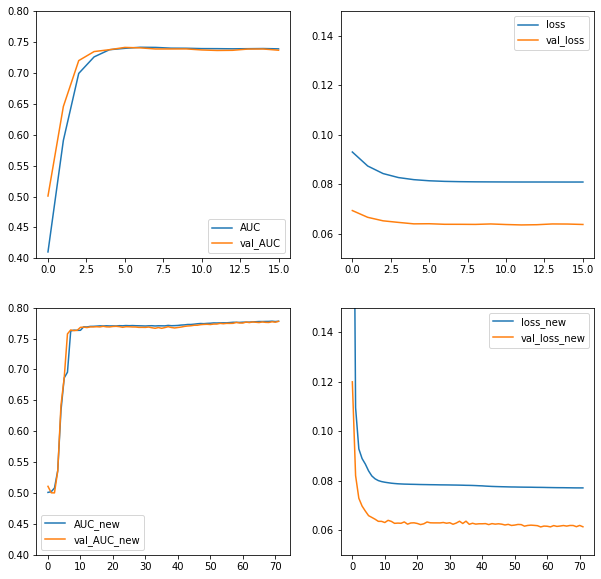

In [ ]:
import matplotlib.pyplot as pt
pt.figure(figsize=[10,10])
pt.subplot(2,2,1)
pt.plot(history.history["AUC"],label="AUC")
pt.plot(history.history["val_AUC"],label="val_AUC")
pt.ylim(0.40,0.80)
pt.legend()
pt.subplot(2,2,2)
pt.plot(history.history["loss"],label="loss")
pt.plot(history.history["val_loss"],label="val_loss")
pt.ylim(0.05,0.15)
pt.legend()
pt.subplot(2,2,3)
pt.plot(history_new.history["AUC"],label="AUC_new")
pt.plot(history_new.history["val_AUC"],label="val_AUC_new")
pt.ylim(0.40,0.80)
pt.legend()
pt.subplot(2,2,4)
pt.plot(history_new.history["loss"],label="loss_new")
pt.plot(history_new.history["val_loss"],label="val_loss_new")
pt.ylim(0.05,0.15)
pt.legend()

In [ ]:
print("AUC=",ml_fin_ev[1])
print("AUC_new=",ml_ev[1])
print("RWA=",ml_fin_ev[2])
print("RWA_new=",ml_ev[2])
print("delta RWA=",round(100-ml_ev[2]*100/ml_fin_ev[2],2),"%")

AUC= 0.7406470775604248
AUC_new= 0.7772399187088013
RWA= 42197.65234375
RWA_new= 39856.41796875
delta RWA= 5.55 %


In [ ]:
#Il modello RNN stima con più accuratezza (AUC 0.78 contro AUC 0.74), ed il capitale regolamentare assorbito dal set di validazione scende da 42K a 40K, un risparmio del 5%